In [1]:
# demo leadfield plot, requires NYhead leadfield model from:
# https://www.parralab.org/nyhead/sa_nyhead.mat
# documentation here: https://www.parralab.org/nyhead/

In [2]:
from h5py import File
import pyvista as pv
import numpy as np
import mne
import neurodsp.sim as sim
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

In [3]:
def get_dipole_location(channel, electrodes, ch_names, pos, offset=(0, 0, 0)):
    """Returns the index of the the mesh node closest to a chosen electrode
        position with a potential offset.
    Convenience function for quickly locating dipoles.

    Parameters
    ----------
    channel : str, name of channel the source should be close to.
    electrodes : array (n_channels x 6) coordinates of electrodes.
    ch_names : list (n_channels), list of channel names.
    offset : list (3), xyz-coordinates of offset with respect to channel.
    pos : coordinates of gray matter mesh.

    Returns
    -------
        idx_source : index of node in gray matter mesh
    """
    idx_chan = np.where(np.array(ch_names) == channel)
    xyz_chan = electrodes[idx_chan[0], :3]
    xyz_chan += np.array(offset)[np.newaxis]
    idx_source = np.argmin(np.sum((pos - xyz_chan) ** 2, axis=1))

    return idx_source


def plot_mesh(field, plotter, color, opacity=1):
    """Visualizes a specific field from NYhead with pyvista and returns
        corresponding node positions.

    Parameters
    ----------
    field : str, field in NYhead matfile structure which should be visualized.
    plotter : pyvista plotter
    color : str, color of mesh.
    opacity : float, regulate opacity of mesh.

    Returns
    -------
    pos : array, xyz-coordinates of nodes in mesh.

    """

    pos = f["sa"][field]["vc"][:].T

    # structure for triangular faces as required by pyivsta
    tri = f["sa"][field]["tri"][:].T - 1
    faces = np.hstack((3 * np.ones((tri.shape[0], 1)), tri))
    faces = faces.astype("int")

    cloud = pv.PolyData(pos, faces)
    actor = plotter.add_mesh(cloud, color=color, opacity=opacity)
    return pos


def plot_electrodes(electrodes, plotter, color="w"):
    """Plot electrodes as small cyclinders into a specific pyvista plotter.

    Parameters
    ----------
    electrodes : array, (n_electrodes x 6) electrode coordinates and normals.
    plotter : pyvista plotter
    color : str, color of electrodes.
    """
    for i in range(len(electrodes)):
        cylinder = pv.Cylinder(
            center=electrodes[i, :3],
            direction=electrodes[i, 3:],
            radius=3.5,
            height=2.0,
        )
        plotter.add_mesh(cylinder, color=color)


def get_channel_names(h5_file):
    """Flatten electrode names into list.
    Parameters
    ----------
    h5_file : H5 file object from which electrode names should be extracted.
    """
    ch_ref = [ch[0] for ch in h5_file["sa"]["clab_electrodes"][:]]
    ch_names = []
    for ch in ch_ref:
        ch_name = "".join([chr(i[0]) for i in h5_file[ch][:]])
        ch_names.append(ch_name)

    ch_names = np.array(ch_names)

    return ch_names


def mu_wave(time, shift=0, wave_shift=1, main_freq=10):
    """
    Create a non-sinusoidal signal as a sum of two sine-waves with fixed
    phase-lag.

    Parameters:
    ----------
    time : array, time interval in seconds.
    shift : sets initial phase of oscillation
    wave_shift : float, phase lag in radians of faster oscillation to slower.
    main_freq : float, base frequency of oscillation.

    Returns:
    --------
    signal : array, non-sinusoidal signal over time

    """
    amp_A = 1.0
    amp_B = 0.25
    alpha = amp_A * np.sin(main_freq * 2 * np.pi * (time + shift))
    beta = amp_B * np.sin(
        main_freq * 2 * np.pi * 2 * (time + shift) + wave_shift
    )
    signal = alpha + beta

    return signal

In [4]:
np.random.seed(3)
#pv.set_plot_theme("document")
#plt.ion()


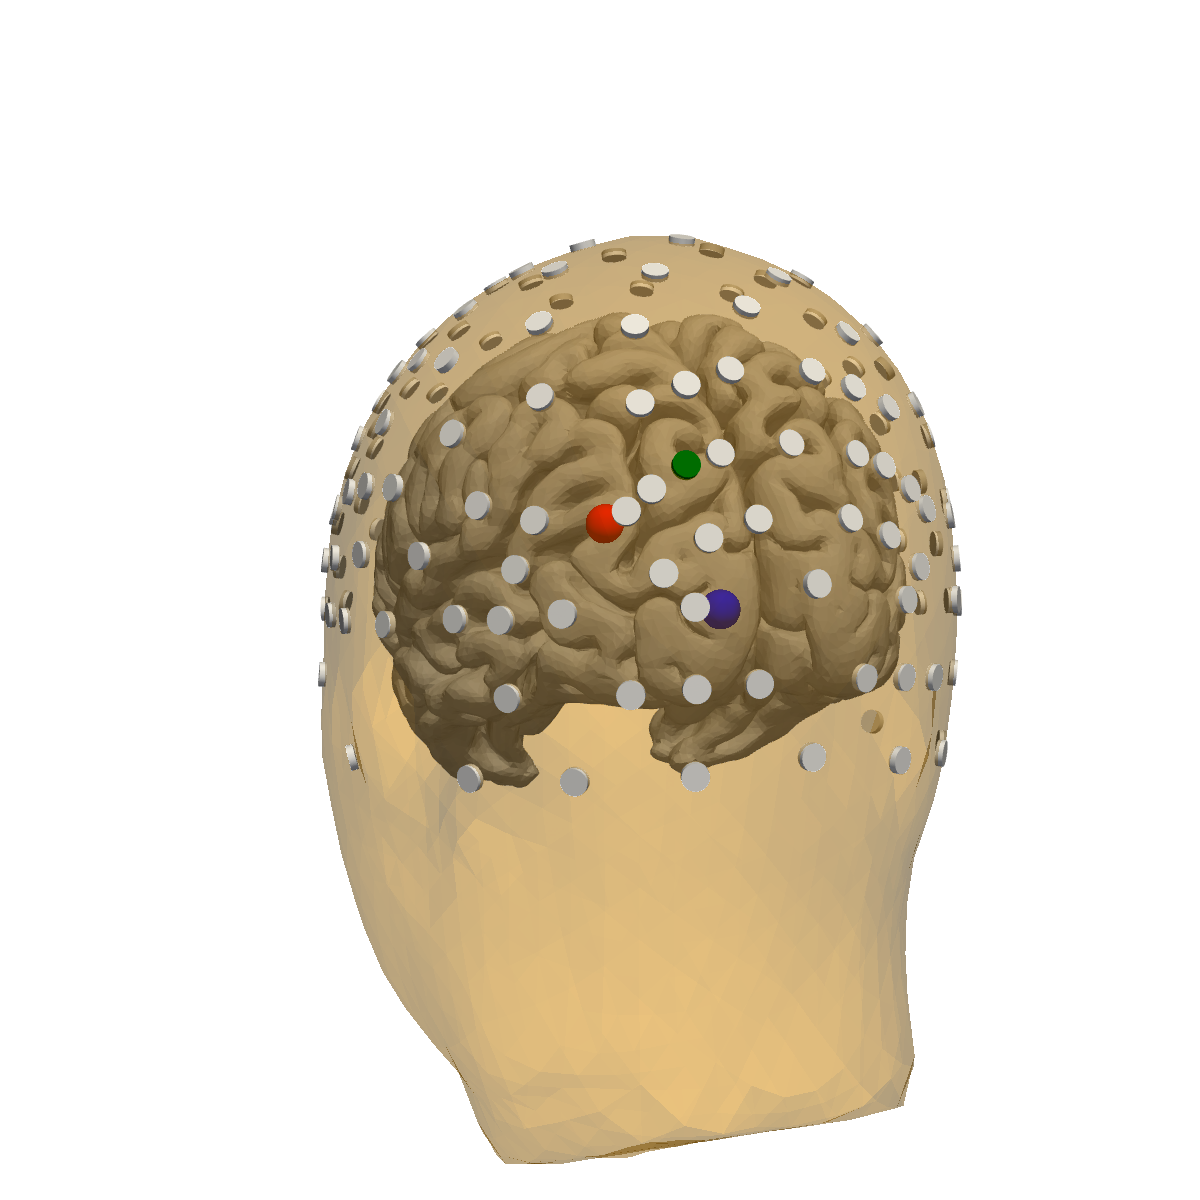

[(-287.6382881416541, -582.8929706171955, 50.0),
 (0.0, 0.0, 0.0),
 (0.0, 0.0, 1.0)]

In [5]:
# load lead field matrix
f = File("data/sa_nyhead.mat", "r")

# extract channel names
ch_names = get_channel_names(f)

# 3d electrode positions
electrodes = f["sa"]["locs_3D"][:].T

# remove lower electrodes for aesthetical reasons
idx_select = electrodes[:, 2] > -40
electrodes = electrodes[idx_select, :]

LF = f["sa"]["cortex75K"]["V_fem_normal"][:]
LF = LF[:, idx_select]
ch_names = ch_names[idx_select]

# select an electrode for plotting
selected_channel = "PO3h"
idx_chan = np.where(np.array(ch_names) == selected_channel)
electrodes_selected = electrodes[idx_chan]


# plot 3d brain
plotter = pv.Plotter(off_screen=True, window_size=(1200, 1200))
plot_mesh(field="head", plotter=plotter, color="orange", opacity=0.3)
pos_brain = plot_mesh(
    field="cortex75K", plotter=plotter, color="#AAAAAA", opacity=1
)



# find dipole close to channel location: PP05 and then shift around a bit
idx_source1 = get_dipole_location(
    channel="PPO5",
    electrodes=electrodes,
    ch_names=ch_names,
    offset=[15, 0, 0],
    pos=pos_brain,
)
idx_source2 = get_dipole_location(
    channel="O1",
    electrodes=electrodes,
    ch_names=ch_names,
    offset=[10, 0, 0],
    pos=pos_brain,
)

# extract the lead field weights a_i for the two sources for the chosen channel
# channel activity x_i is a linear mixture of the two sources s_1 and s_2
# x_i = a_1i * s_1 + a_2i * s_2
LF_coef = LF[[idx_source1, idx_source2], idx_chan]


# plot 2 dipole locations
source = pos_brain[[idx_source1], :]
plotter.add_mesh(
    source, render_points_as_spheres=True, point_size=40, color="r"
)

source = pos_brain[[idx_source2], :]
plotter.add_mesh(
    source, render_points_as_spheres=True, point_size=40, color="b"
)

plot_electrodes(electrodes, plotter, color="w")
plot_electrodes(electrodes_selected, plotter, color="green")




# set camera position for 3d visualization
r = 650
angle = 3.6
cpos = [
    (r * np.sin(angle), r * np.cos(angle), 50),
    (0, 0, 0),
    (0, 0, 1),
]

# save figure for display with mpimg later
plot_3d_filename = "mesh_nyhead.png"
plotter.set_background(None)
plotter.show(
    cpos=cpos,
    interactive_update=False,
    screenshot=plot_3d_filename,
)

In [6]:
import seaborn as sns
sns.set_context('poster')

In [7]:
# make 2 signals with non-sinusoidal shape and different peak frequency
nr_samples = 10000
fs = 1000
nr_seconds = nr_samples / fs
t = np.linspace(0, nr_seconds, nr_samples)

# SCENARIO 1: double peak
main_freq1 = 11
main_freq2 = 9
noise_level = 1.75
exponent = -2

noise1 = noise_level * sim.sim_powerlaw(nr_seconds, fs, exponent=exponent)
noise2 = noise_level * sim.sim_powerlaw(nr_seconds, fs, exponent=exponent)

nr_signals = 3
epochs = np.zeros((nr_signals, nr_samples))
epochs[0] = mu_wave(t, main_freq=main_freq1) + noise1
epochs[1] = mu_wave(t, main_freq=main_freq2) + noise2
epochs[2] = LF_coef[0, 0] * epochs[0] + LF_coef[0, 1] * epochs[1]

# make MNE object & compute spectra
ch_signals = ["signal%i" % i for i in range(nr_signals)]
info = mne.create_info(ch_signals, fs, ch_types="eeg")
raw = mne.io.RawArray(epochs, info)
psd, freq = mne.time_frequency.psd_welch(
    raw, fmin=1, fmax=35, n_fft=2001, n_overlap=500)

Creating RawArray with float64 data, n_channels=3, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.001 (s)


In [8]:
# SCENARIO 2: double peak
main_freq3 = 10
noise_level = 1.75
exponent = -2
noise1 = noise_level * sim.sim_powerlaw(nr_seconds, fs, exponent=exponent)
noise2 = noise_level * sim.sim_powerlaw(nr_seconds, fs, exponent=exponent)

epochs = np.zeros((nr_signals, nr_samples))
epochs[0] = mu_wave(t, main_freq=main_freq3, shift=0) + noise1
epochs[1] = mu_wave(t, main_freq=main_freq3, shift=np.pi) + noise2
epochs[2] = LF_coef[0, 0] * epochs[0] + LF_coef[0, 1] * epochs[1]

# make MNE object & compute spectra
ch_signals = ["signal%i" % i for i in range(nr_signals)]
info = mne.create_info(ch_signals, fs, ch_types="eeg")
raw2 = mne.io.RawArray(epochs, info)
psd2, freq = mne.time_frequency.psd_welch(
    raw2, fmin=1, fmax=35, n_fft=2001, n_overlap=500
)

# crop for plotting
raw.crop(0, 1)
raw2.crop(0, 1)

Creating RawArray with float64 data, n_channels=3, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.001 (s)


<RawArray | 3 x 1001 (1.0 s), ~34 kB, data loaded>

In [9]:
# aesthetics
colors = ("#CC2B1C", "#3C2C71", "#115C12")

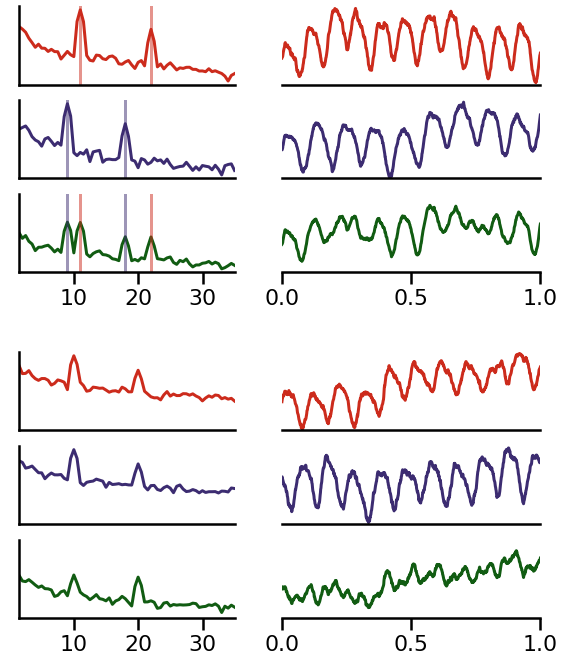

In [16]:
# create figure
fig = plt.figure(figsize=(12, 10))

outer_grid = gridspec.GridSpec(
    1, 2,
    figure=fig,
    width_ratios=[1, 2],
    top=0.95,
    bottom=0.1,
    left=0.0,
    right=0.95,
    wspace=0.1,
)

# gs_heads = gridspec.GridSpecFromSubplotSpec(
#     3,
#     1,
#     subplot_spec=outer_grid[0],
#     height_ratios=[1, 1, 2.5],
#     wspace=0.05,
#     hspace=0.05,
# )

# grid for the time series
gs_TS = gridspec.GridSpecFromSubplotSpec(
    2, 1, 
    hspace=0.3,
    subplot_spec=outer_grid[1], 
)

# plot time series and PSDs for scenario #1
gs_TS1 = gridspec.GridSpecFromSubplotSpec(
    3, 2, subplot_spec=gs_TS[0], width_ratios=[1, 1.2])

for i in range(nr_signals):
    ax00 = fig.add_subplot(gs_TS1[i, 0])
    ax00.set(
        #xlabel="frequency [Hz]",
        #ylabel="log PSD",
        xlim=(freq[0], freq[-1]),
        xticks=[0, 10, 20, 30],
        yticks=[],
        yticklabels=[],
    )
    ax00.semilogy(freq, psd[i], color=colors[i])
    ax00.set_yticks([])

    if i != 1:
        ax00.axvline(main_freq1, color=colors[0], alpha=0.5)
        ax00.axvline(2 * main_freq1, color=colors[0], alpha=0.5)

    if i > 0:
        ax00.axvline(main_freq2, color=colors[1], alpha=0.5)
        ax00.axvline(2 * main_freq2, color=colors[1], alpha=0.5)
    
    if i < 2:
        ax00.set_xlabel(None)
        ax00.set_xticks([])

    ax00.get_yaxis().set_major_formatter(plt.NullFormatter())
    sns.despine(ax=ax00)

    ax_ts = fig.add_subplot(gs_TS1[i, 1])
    e1 = raw._data[i]
    ax_ts.plot(raw.times, e1, color=colors[i])
    ax_ts.set(
        xlim=(0, 1),
        #xlabel="time [s]",
        yticks=[],
        ylim=(e1.min() - 0.1, e1.max() + 0.1))
    
    if i < 2:
        ax_ts.set_xlabel(None)
        ax_ts.set_xticks([])

    
    sns.despine(ax=ax_ts, left=True)
    


# plot time series and PSDs for scenario #2
gs_TS2 = gridspec.GridSpecFromSubplotSpec(
    3, 2, subplot_spec=gs_TS[1], width_ratios=[1, 1.2]
)

for i in range(nr_signals):
    ax_psd = fig.add_subplot(gs_TS2[i, 0], sharey=ax00)
    ax_psd.set(
        #xlabel="frequency [Hz]",
        #ylabel="log PSD",
        xlim=(freq[0], freq[-1]),
        xticks=[0, 10, 20, 30],
        yticks=[],
        yticklabels=[],
    )
    ax_psd.semilogy(freq, psd2[i], color=colors[i])  # , color=colors[i])
    ax_psd.get_yaxis().set_major_formatter(plt.NullFormatter())
    sns.despine(ax=ax_psd)

    ax_ts = fig.add_subplot(gs_TS2[i, 1])
    e2 = raw2._data[i]
    ax_ts.plot(raw.times, e2, color=colors[i])
    ax_ts.set(
        xlim=(0, 1),
        #xlabel="time [s]",
        yticks=[],
        ylim=(e2.min() - 0.1, e2.max() + 0.1),
    )
    
    if i < 2:
        ax_ts.set_xlabel(None)
        ax_ts.set_xticks([])
        ax_psd.set_xlabel(None)
        ax_psd.set_xticks([])
    ax_psd.set_yticks([])
        
    sns.despine(ax=ax_ts, left=True)
    

plt.savefig("figures/16_spectral_peaks.pdf", bbox_inches='tight')

In [11]:
# make an MNE datastructure, for plotting the topographies
info = mne.create_info(list(ch_names), 1000, "eeg")
ch_pos = dict(zip(ch_names, electrodes[:, :3]))
montage = mne.channels.make_dig_montage(ch_pos, coord_frame="head")

# montage = mne.channels.make_standard_montage("standard_1005")  # looks strange
data = np.zeros((len(ch_names), 10))

# set leadfield as data, such that corresponding channel rows are dropped automatically
data = LF[[idx_source1, idx_source2], :].T

raw3 = mne.io.RawArray(data, info)
raw3.set_montage(montage)


# mark selected channel in the topoplot
idx_chan = np.where(np.array(raw2.ch_names) == selected_channel)
mask = np.zeros((len(raw3.ch_names),), dtype="bool")
mask[idx_chan] = True

mask_params = dict(
    marker="o",
    markerfacecolor="w",
    markeredgecolor=colors[2],
    linewidth=0,
    markersize=4,
)

Creating RawArray with float64 data, n_channels=160, n_times=2
    Range : 0 ... 1 =      0.000 ...     0.001 secs
Ready.


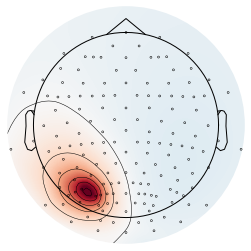

In [12]:
# leadfield for source 1
idx = 0
fig, ax = plt.subplots()
mne.viz.plot_topomap(
    raw3.get_data()[:, idx],
    raw3.info,
    mask=mask,
    mask_params=mask_params)
#ax.set_ylabel(f"source {idx + 1}", color=colors[idx])
fig.savefig("figures/16_topo1.pdf", bbox_inches='tight')

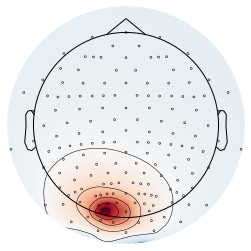

In [13]:
idx = 1
fig, ax = plt.subplots()
mne.viz.plot_topomap(
    raw3.get_data()[:, idx],
    raw3.info,
    mask=mask,
    mask_params=mask_params)
#ax.set_ylabel(f"source {idx + 1}", color=colors[idx])
fig.savefig("figures/16_topo2.pdf", bbox_inches='tight')

(180.0, 1100.0, 1200.0, 150.0)

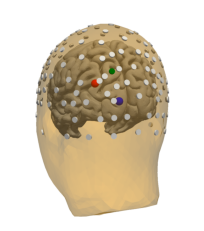

In [14]:

## load the 3d head image
#ax_head = fig.add_subplot(gs_heads[2, 0])
_, ax_head = plt.subplots()
file_name = "mesh_nyhead.png"
img = mpimg.imread(file_name)
ax_head.imshow(img)
ax_head.set_xlim(180, 1100)
ax_head.set_ylim(1200, 150)
ax_head.axis("off")

#fig.savefig("figures/06_spatial_mixing.pdf", dpi=300)
#fig.show()

In [15]:
# # create figure
# colors = ("#CC2B1C", "#3C2C71", "#115C12")
# fig = plt.figure(figsize=(8, 7.8))

# outer_grid = gridspec.GridSpec(
#     1,
#     2,
#     figure=fig,
#     width_ratios=[1, 2],
#     top=0.95,
#     bottom=0.1,
#     left=0.0,
#     right=0.95,
#     wspace=0.1,
# )

# gs_heads = gridspec.GridSpecFromSubplotSpec(
#     3,
#     1,
#     subplot_spec=outer_grid[0],
#     height_ratios=[1, 1, 2.5],
#     wspace=0.05,
#     hspace=0.05,
# )

# # grid for the time series
# gs_TS = gridspec.GridSpecFromSubplotSpec(
#     2, 1, subplot_spec=outer_grid[1], hspace=0.3
# )

# # plot time series and PSDs for scenario #1
# gs_TS1 = gridspec.GridSpecFromSubplotSpec(
#     3, 2, subplot_spec=gs_TS[0], width_ratios=[1, 1.2]
# )

# for i in range(nr_signals):
#     ax00 = fig.add_subplot(gs_TS1[i, 0])
#     ax00.set(
#         xlabel="frequency [Hz]",
#         ylabel="log PSD",
#         xlim=(freq[0], freq[-1]),
#         xticks=[0, 10, 20, 30],
#         yticks=[],
#         yticklabels=[],
#     )
#     ax00.semilogy(freq, psd[i], color=colors[i])

#     if i != 1:
#         ax00.axvline(main_freq1, color=colors[0], alpha=0.5)
#         ax00.axvline(2 * main_freq1, color=colors[0], alpha=0.5)

#     if i > 0:
#         ax00.axvline(main_freq2, color=colors[1], alpha=0.5)
#         ax00.axvline(2 * main_freq2, color=colors[1], alpha=0.5)

#     ax00.get_yaxis().set_major_formatter(plt.NullFormatter())
#     sns.despine(ax=ax00)

#     ax_ts = fig.add_subplot(gs_TS1[i, 1])
#     e = raw._data[i]
#     ax_ts.plot(raw.times, e, color=colors[i])
#     ax_ts.set(
#         xlim=(0, 1),
#         xlabel="time [s]",
#         yticks=[],
#         ylim=(e.min() - 0.1, e.max() + 0.1),
#     )
#     sns.despine(ax=ax_ts, left=True)


# # plot time series and PSDs for scenario #2
# gs_TS2 = gridspec.GridSpecFromSubplotSpec(
#     3, 2, subplot_spec=gs_TS[1], width_ratios=[1, 1.2]
# )
# for i in range(nr_signals):
#     ax_psd = fig.add_subplot(gs_TS2[i, 0], sharey=ax00)
#     ax_psd.set(
#         xlabel="frequency [Hz]",
#         ylabel="log PSD",
#         xlim=(freq[0], freq[-1]),
#         xticks=[0, 10, 20, 30],
#         yticks=[],
#         yticklabels=[],
#     )
#     ax_psd.semilogy(freq, psd2[i], color=colors[i])  # , color=colors[i])
#     ax_psd.get_yaxis().set_major_formatter(plt.NullFormatter())
#     sns.despine(ax=ax_psd)

#     ax_ts = fig.add_subplot(gs_TS2[i, 1])
#     e = raw2._data[i]
#     ax_ts.plot(raw.times, e, color=colors[i])
#     ax_ts.set(
#         xlim=(0, 1),
#         xlabel="time [s]",
#         yticks=[],
#         ylim=(e.min() - 0.1, e.max() + 0.1),
#     )
#     sns.despine(ax=ax_ts, left=True)


# # make an MNE datastructure, for plotting the topographies
# info = mne.create_info(list(ch_names), 1000, "eeg")
# ch_pos = dict(zip(ch_names, electrodes[:, :3]))
# montage = mne.channels.make_dig_montage(ch_pos, coord_frame="head")

# # montage = mne.channels.make_standard_montage("standard_1005")  # looks strange
# data = np.zeros((len(ch_names), 10))

# # set leadfield as data, such that corresponding channel rows are dropped automatically
# data = LF[[idx_source1, idx_source2], :].T

# raw2 = mne.io.RawArray(data, info)
# #raw2.set_montage(montage, raise_if_subset=False)  # , on_missing="ignore")
# raw2.set_montage(montage)#, raise_if_subset=False)  # , on_missing="ignore")


# # mark selected channel in the topoplot
# idx_chan = np.where(np.array(raw2.ch_names) == selected_channel)
# mask = np.zeros((len(raw2.ch_names),), dtype="bool")
# mask[idx_chan] = True

# mask_params = dict(
#     marker="o",
#     markerfacecolor="w",
#     markeredgecolor=colors[2],
#     linewidth=0,
#     markersize=4,
# )

# # leadfield for source 1 & source 2
# for idx in range(2):
#     ax0 = fig.add_subplot(gs_heads[idx, 0])
#     ax0.set_ylabel(f"source {idx + 1}", color=colors[idx])
#     mne.viz.plot_topomap(
#         raw2.get_data()[:, idx],
#         raw2.info,
#         axes=ax0,
#         mask=mask,
#         mask_params=mask_params,
#     )


# # load the 3d head image
# ax_head = fig.add_subplot(gs_heads[2, 0])
# file_name = "mesh_nyhead.png"
# img = mpimg.imread(file_name)
# ax_head.imshow(img)
# ax_head.set_xlim(180, 1100)
# ax_head.set_ylim(1200, 150)
# ax_head.axis("off")

# fig.savefig("figures/06_spatial_mixing.pdf", dpi=300)
# fig.show()